<div class="alert alert-info"><h1> Strategy Backtesting Using Python (DMP-1) Assignment Solutions
    </h1><br><br>
Date created: 22/05/2020<br>
Last updated on: 28/12/2021</div>

#### Fetching the required data and importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as web
import warnings

warnings.filterwarnings('ignore')


end_date = dt.date(2020, 4, 30)
start_date = dt.date(2015, 1, 2)

df = yf.download("MSFT", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.193840,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.815025,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.215977,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.726929,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.925034,29645200


<div class="alert alert-info"><strong>
Q1: Try out the ‘Big Moves Monday’ strategy on the above data with standard conditions as taught in the class. Now back-test the strategy again but this this time tweak condition 3 such that 'ibs' value must be lower than 0.8. Comment on the results. 
    <p style="text-align:right;">(5 marks)</p>
    </strong>    </div>

In [ ]:
# Creating required functions for standard backtesting as taught in the class
def compute_daily_returns(data):
    """ 
    The function computes daily log returns based on the Close prices in the pandas DataFrame
    and stores it in a column  called 'cc_returns'.
    """
    data['cc_returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))


def compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Big Moves on Mondays" trading strategy.
    """
    # Columns created to check condition 1
    data['day'] = data.index.day_name()
    data['prev_day'] = data['day'].shift(1)
    data['four_days_after'] = data['day'].shift(-4)

    # Columns created to check condition 2
    data['relative_range'] = (data['High'] - data['Low']) / data['Adj Close']
    data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()

    # Column created to check condition 3
    data['ibs'] = (data['Adj Close'] - data['Low']) / \
        (data['High'] - data['Low'])


def show_backtesting_results(data):
    """
    The function displays the cumulative returns from the trading strategy and a buy-and-hold strategy. 
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run ONLY after the function backtest_strategy.
    """
    print('Buy and hold returns: ', np.round(
        data['cc_returns'].cumsum()[-1], 2))
    print('Strategy returns: ', np.round(
        data['strategy_returns'].cumsum()[-1], 2))

    data[['cc_returns', 'strategy_returns']] = data[[
        'cc_returns', 'strategy_returns']].cumsum()


def backtest_strategy(data, ma_threshold, ibs_threshold):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Big Moves on Mondays" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    # compute the daily returns and the indicators using the functions we defined
    compute_daily_returns(data)
    compute_indicators(data)

    data['condition1'] = np.where((data['day'] == 'Monday')
                                  & (data['prev_day'] == 'Friday')
                                  & (data['four_days_after'] == 'Friday'),
                                  1, 0)

    data['condition2'] = np.where((1 - data['Adj Close'] / data['Adj Close'].shift(1))
                                  >= ma_threshold * data['rel_range_ma'], 1, 0)

    data['condition3'] = np.where(data['ibs'] < ibs_threshold, 1, 0)

    data['signal'] = np.where((data['condition1'] == 1)
                              & (data['condition2'] == 1)
                              & (data['condition3'] == 1),
                              1, 0)

    # The below two statements ensures that we can directly calculate strategy returns by multiplying the
    # columns 'position' and 'cc_returns'
    data['signal'] = data['signal'].shift(1)

    data['position'] = data['signal'].replace(
        to_replace=0, method='ffill', limit=3)

    data['strategy_returns'] = data['cc_returns'] * data['position']

    # print the results
    show_backtesting_results(data)

In [ ]:
# Backtesting using standard conditions
df1 = df.copy()
backtest_strategy(data=df1, ma_threshold=0.25, ibs_threshold=0.3)

Buy and hold returns:  1.44
Strategy returns:  0.74


In [ ]:
# Backtesting using the tweaked ibs and ma condition
backtest_strategy(data=df1, ma_threshold=0.15, ibs_threshold=0.8)

Buy and hold returns:  1.44
Strategy returns:  0.84


In [ ]:
# The tweaked version produces better results for this stock in the given timeframe.

<div class="alert alert-info"><strong>
Q2: You have seen a strategy based on MACD indicator in the class. In a similar way, back-test the 20 day Bollinger band strategy on the above equity (buy when the price crosses the lower band and sell when the price touches the upper band. Exit from either position when the price crosses the 20 day MA). <p style="text-align:right;">(5 marks)</p>
    </strong>    </div>

In [ ]:
df2 = df.copy()

In [ ]:
df2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.193840,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.815025,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.215977,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.726929,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.925034,29645200


In [ ]:
df2['20_day_sma'] = df2['Adj Close'].rolling(window=20, center=False).mean()
df2['20_day_std'] = df2['Adj Close'].rolling(window=20, center=False).std()
df2.dropna(inplace=True)

In [ ]:
df2['upper_band'] = df2['20_day_sma'] + 2 * df2['20_day_std']
df2['lower_band'] = df2['20_day_sma'] - 2 * df2['20_day_std']

In [ ]:
df2['prev Adj Close'] = df2['Adj Close'].shift()
df2['prev upper_band'] = df2['upper_band'].shift()
df2['prev lower_band'] = df2['lower_band'].shift()

In [ ]:
df2['signal'] = np.where((df2['Adj Close'] > df2['upper_band']) & (
    df2['prev Adj Close'] < df2['prev upper_band']), -1, 0)
df2['signal'] = np.where((df2['Adj Close'] < df2['lower_band']) & (
    df2['prev Adj Close'] > df2['prev lower_band']), 1, df2['signal'])

In [ ]:
df2['signal'].value_counts()

 0    1246
-1      51
 1      24
Name: signal, dtype: int64

In [ ]:
df2['position'] = df2['signal'].replace(to_replace=0, method='ffill')
df2['position'].value_counts()

-1    805
 1    488
 0     28
Name: position, dtype: int64

<AxesSubplot:xlabel='Date'>

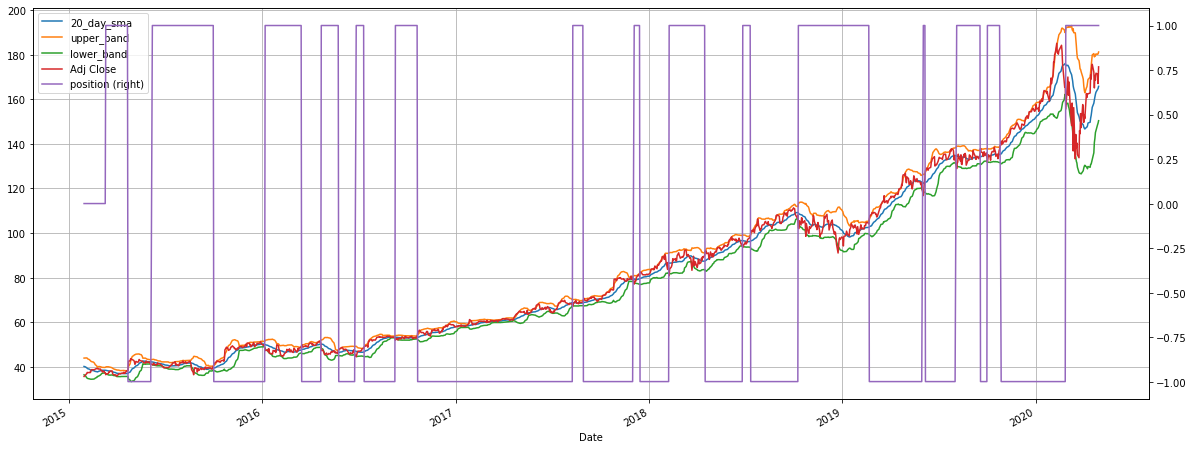

In [ ]:
x = df2[['20_day_sma', 'upper_band', 'lower_band', 'Adj Close', 'position']]
x.plot(secondary_y='position', grid=True, figsize=(20, 8))

In [ ]:
df2['B&H_returns'] = df2['Adj Close'].pct_change()
df2['strategy_returns'] = df2['B&H_returns']*df2['position'].shift(1)

In [ ]:
df2['B&H_cumulative'] = (1+df2['B&H_returns']).cumprod() - 1
df2['strategy_cumulative'] = (1+df2['strategy_returns']).cumprod() - 1

<AxesSubplot:xlabel='Date'>

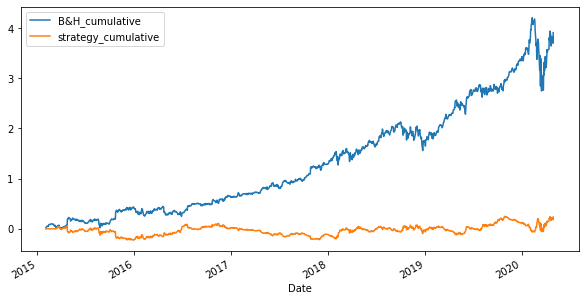

In [ ]:
df2[['B&H_cumulative', 'strategy_cumulative']].plot(figsize=(10, 5))

In [ ]:
# B&H significantly outperforms our Bollinger band startegy over this period

<div class="alert alert-info"><strong>Q3: Write a customized function that computes returns for the exponential moving average (EMA) strategy (discussed in class) for different windows(spans). Find the value between 1 and 30 which produces best overall total return .<p style="text-align:right;">(5 marks)</p>
    </strong>    </div>

In [ ]:
# Defining the required function

def optimizing_EMA(data, ema):

    # Prepare for vectorization
    data['cc_returns'] = data['Close'].pct_change()
    data['ema'] = data['Close'].ewm(span=ema, adjust=False).mean()

    # Vectorized backtest using numpy.where
    data['position'] = np.where((data['Close'] > data['ema']), 1, 0)
    data['position'] = data['position'].shift(1)

    # Calculating returns
    data['strategy_returns'] = data['cc_returns'] * data['position']
    data['strategy_returns'] = (1+data['strategy_returns']).cumprod()

    # output
    return float(data['strategy_returns'].iloc[-1]), ema

In [ ]:
# read data into a dataframe
df3 = df.copy()

# Finding optimal value for EMA
ema_values = range(1, 30)
returns_vs_ema = []

for i in ema_values:
    returns, ema = optimizing_EMA(df3, i)
    print(f"Ema value {ema} gives a return of {returns}")
    returns_vs_ema.append(optimizing_EMA(df3, i))

print(f"The ema value producing max returns is {max(returns_vs_ema)}")

Ema value 1 gives a return of 1.0
Ema value 2 gives a return of 1.110207117330151
Ema value 3 gives a return of 0.8876029410152431
Ema value 4 gives a return of 0.9256493644944932
Ema value 5 gives a return of 0.7952505861922805
Ema value 6 gives a return of 0.8559896922856314
Ema value 7 gives a return of 0.8864989634966223
Ema value 8 gives a return of 0.774244886974616
Ema value 9 gives a return of 0.8412800528885287
Ema value 10 gives a return of 0.944525824697591
Ema value 11 gives a return of 1.1345083620801732
Ema value 12 gives a return of 1.1180009181618116
Ema value 13 gives a return of 1.2990220373022032
Ema value 14 gives a return of 1.335851828568631
Ema value 15 gives a return of 1.3124609775134448
Ema value 16 gives a return of 1.242807387326424
Ema value 17 gives a return of 1.2538945374754782
Ema value 18 gives a return of 1.2251233874860905
Ema value 19 gives a return of 1.260080065506285
Ema value 20 gives a return of 1.2246780976228528
Ema value 21 gives a return of

<div class="alert alert-info"><strong>Q4: The moving average crossover (MAC) code is implemented where we always have an open position. Calculate returns where short selling is not allowed. Plot a graph comparing returns from buy-and-hold, no short selling, and the one we did in class. Comment on your results. <p style="text-align:right;">(5 marks)</p>
    </strong>    </div>

In [ ]:
# creating a copy
df4 = df.copy()

# defining moving average window parameters
short_period = 50  # the shorter lookback period
long_period = 200   # the longer lookback period

# calculating MAs
df4['ShortMA'] = df4['Adj Close'].rolling(
    window=short_period, center=False).mean()
df4['LongMA'] = df4['Adj Close'].rolling(
    window=long_period, center=False).mean()

df4['ShortMA2'] = df4['ShortMA'].shift(1)
df4['LongMA2'] = df4['LongMA'].shift(1)

# drop null values
df4.dropna(inplace=True)

# inspect the dataframe
print(df4.shape)
print(df4.head())
print(df4.tail())

(1140, 10)
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2015-10-19  47.419998  47.880001  47.020000  47.619999  42.805016   29387600   
2015-10-20  47.439999  47.810001  47.020000  47.770000  42.939850   30802200   
2015-10-21  47.919998  47.990002  47.110001  47.200001  42.427498   25144300   
2015-10-22  47.529999  48.950001  47.090000  48.029999  43.173561   56637100   
2015-10-23  52.299999  54.070000  52.250000  52.869999  47.524189  135227100   

              ShortMA     LongMA   ShortMA2    LongMA2  
Date                                                    
2015-10-19  40.286800  39.928196  40.265475  39.920140  
2015-10-20  40.300285  39.938820  40.286800  39.928196  
2015-10-21  40.319953  39.949877  40.300285  39.938820  
2015-10-22  40.348649  39.962110  40.319953  39.949877  
2015-10-23  40.464536  39.990106  40.348649  39.962110  
                  Open       

In [ ]:
# calculating daily "buy & hold" returns
df4['daily_returns'] = np.log(df4['Adj Close']/df4['Adj Close'].shift(1))
df4['buy & hold cumulative returns'] = np.cumsum(df4['daily_returns'])

buy & hold cumulative returns:  1.41
cumulative returns_short_allowed:  1.06


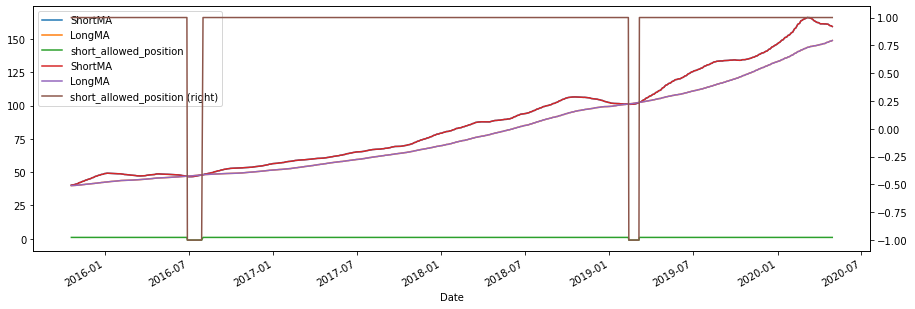

In [ ]:
# long-short strategy
df4.dropna(inplace=True)
df4["short_allowed_position"] = np.where(
    (df4['ShortMA'] > df4['LongMA']), 1, -1)

df4["short_allowed_returns"] = (
    df4["short_allowed_position"].shift())*df4['daily_returns']

df4['cumulative returns_short_allowed'] = df4["short_allowed_returns"].cumsum()
print('buy & hold cumulative returns: ', np.round(
    df4['daily_returns'].cumsum()[-1], 2))
print('cumulative returns_short_allowed: ', np.round(
    df4['short_allowed_returns'].cumsum()[-1], 2))
# Visualizing the long-short strategy
a = df4[['ShortMA', 'LongMA', 'short_allowed_position']].plot()
df4[['ShortMA', 'LongMA', 'short_allowed_position']].plot(
    ax=a, secondary_y='short_allowed_position', figsize=(15, 5))
plt.show()

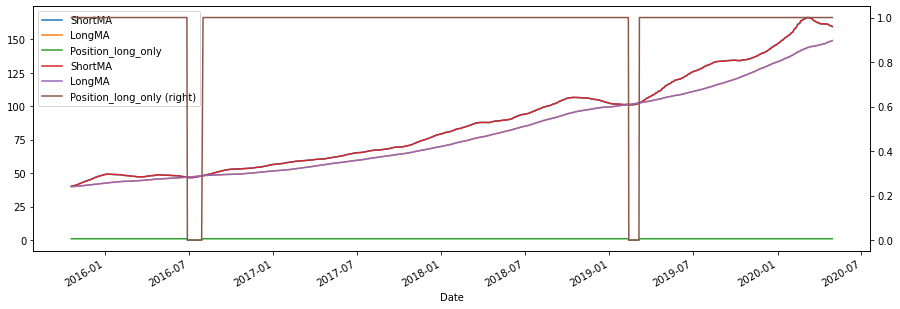

In [ ]:
# Generating positions  & returns in case where short selling is NOT allowed ie "long only" case
df4['Position_long_only'] = np.where((df4['ShortMA'] > df4['LongMA']), 1, 0)

df4['returns_long_only'] = df4['daily_returns'] * \
    (df4['Position_long_only'].shift(1))

df4["cumulative_returns_long_only"] = df4['returns_long_only'].cumsum()


# Visualizing the long only strategy
a = df4[['ShortMA', 'LongMA', 'Position_long_only']].plot()
df4[['ShortMA', 'LongMA', 'Position_long_only']].plot(
    ax=a, secondary_y='Position_long_only', figsize=(15, 5))
plt.show()

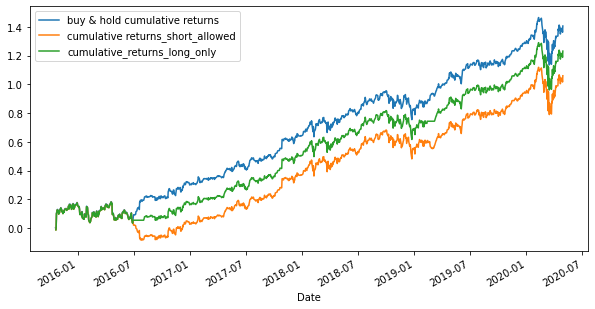

In [ ]:
# plotting cumulative returns for comparison
df4[['buy & hold cumulative returns', 'cumulative returns_short_allowed',
    'cumulative_returns_long_only', ]].plot(figsize=(10, 5))
plt.show()

<div class="alert alert-info"><strong>Q5: Download the data for the following companies TSLA, NFLX, AMZN, GOOG and CVX using the code for automatically downloading multiple stocks from January 1st 2015 to April 30th 2020.  You can use Yahoo Financel for downloading data. (5 Marks)<br>
For the above-mentioned time period<br>
a) Compute the daily returns (assuming you buy at open and sell at close) every day.<br>
b) Compute the hit ratio for each of them (recall that the hit ratio is the ratio of number of positive trades to total number of trades).<br>
c) Compute the cumulative returns for each of them.<br>
Plot them graphically and comment on your results.<p style="text-align:right;">(5 marks)</p>
    </strong>    </div>


In [ ]:
# importing the necessary library
from concurrent import futures

stocksList = ['TSLA', 'GOOG', 'AMZN', 'NFLX', 'CVS']

list_stocks = []

# Keeping track of failed ticker download queries
bad_tickers = []

end = dt.date(2020, 4, 30)
start = dt.date(2015, 1, 2)


def download_stocks(stock):
    try:
        print('Trying to retrieve the %s symbol...\n' % (stock))
        stock_df = web.DataReader(stock, 'yahoo', start, end)
        stock_df['Name'] = stock
        output_name = stock + '.csv'
        list_stocks.append(output_name)
        stock_df.to_csv(output_name)
        print('Symbol %s downloaded successfully.\n' % (stock))
    except:
        bad_tickers.append(stock)
        print('Problems downloading the %s symbol.\n' % (stock))


# We use the concurrent.futures module's ThreadPoolExecutor
# to speed up the downloads by doing them in parallel rather than serially

# Set the maximum thread number
max_workers = 50

workers = min(max_workers, len(stocksList))
# In case a smaller number of stocks than threads was passed in
with futures.ThreadPoolExecutor(workers) as executor:
    res = executor.map(download_stocks, stocksList)
# map allows multiple calls to the given function. It passes each of the items in stocksList (any
# iterable) to the function. Here, it can happen concurrently because of the ThreadPoolExecutor()
# subClass

Trying to retrieve the TSLA symbol...

Trying to retrieve the GOOG symbol...

Trying to retrieve the AMZN symbol...

Trying to retrieve the NFLX symbol...

Trying to retrieve the CVS symbol...

Symbol TSLA downloaded successfully.

Symbol AMZN downloaded successfully.

Symbol NFLX downloaded successfully.

Symbol GOOG downloaded successfully.

Symbol CVS downloaded successfully.



In [ ]:
# A function to take in a stock symbol, reads saved data from the csv file & returns a dataframe containing returns assuming buy at open and sell at close
def returns_calculator(stock):
    stock_df = pd.read_csv(stock + '.csv', index_col='Date')
    stock_df[stock] = np.log(stock_df['Close']/stock_df['Open'])
    stock_Ret = pd.DataFrame(stock_df[stock])
    return(stock_Ret)

In [ ]:
# create a Series
pd.Series(stocksList)

# apply the returns_calculator() to each element of the series and save the new Series in "res"
res = pd.Series(stocksList).apply(returns_calculator)

# Each value in the 'res' Series is a DataFRame of returns

In [ ]:
# Creating an empty dataframe called "result"
result = pd.DataFrame()
result

# taking individual dataframes (each stock) and concatanating it to empty df result on the column axis
for i in res:
    result = pd.concat([i, result], axis=1)

result.head()

,CVS,NFLX,AMZN,GOOG,TSLA
Date,,,,,
2015-01-02,-0.014821,0.014084,-0.013074,-0.007971,-0.016102
2015-01-05,-0.004556,-0.040332,-0.015824,-0.018108,-0.021007
2015-01-06,-0.004236,-0.018023,-0.023263,-0.025647,0.005791
2015-01-07,0.010690,-0.012845,0.003088,-0.011705,-0.011313
2015-01-08,0.011291,0.013910,0.000466,0.009374,-0.010344


HitRatios
 CVS     0.495153
NFLX    0.487696
AMZN    0.498881
GOOG    0.519761
TSLA    0.507830
dtype: float64


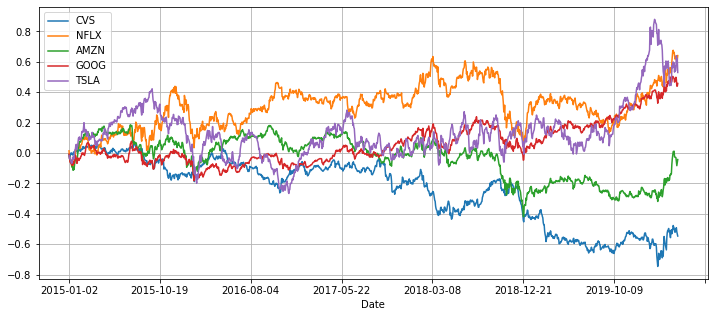

In [ ]:
# Calculating required values and plotting the equity curve

HitRatio = result[result > 0].count()/result.count()
print("HitRatios\n", HitRatio)

Eq_curve = result.cumsum()
Eq_curve.plot(grid=True, figsize=(12, 5))
plt.show()

<div class="alert alert-info"><strong>Another approach for Q5</strong></div>

In [ ]:
tickers = ['TSLA', 'GOOG', 'AMZN', 'NFLX', 'CVS']

end = dt.date(2020, 4, 30)
start = dt.date(2015, 1, 2)

ticker_df = {ticker: yf.download(ticker, start=start, end=end)
             for ticker in tickers}

#ticker_df = yf.download(tickers, group_by='Ticker', start= start, end = end)
#ticker_df = ticker_df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
#ticker_data = {}
# for ticker in tickers:
#    ticker_data[ticker] = ticker_df[ticker_df['Ticker']==ticker]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
ticker_data['TSLA'].head()

,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2015-01-02,TSLA,43.862000,43.862000,44.650002,42.652000,44.574001,23822000
2015-01-05,TSLA,42.018002,42.018002,43.299999,41.431999,42.910000,26842500
2015-01-06,TSLA,42.256001,42.256001,42.840000,40.841999,42.012001,31309500
2015-01-07,TSLA,42.189999,42.189999,42.956001,41.956001,42.669998,14842000
2015-01-08,TSLA,42.124001,42.124001,42.759998,42.001999,42.562000,17212500


Hit Ratio for TSLA is : 0.5089686098654709 

Hit Ratio for GOOG is : 0.5317401045556386 

Hit Ratio for AMZN is : 0.5485799701046338 

Hit Ratio for NFLX is : 0.5052395209580839 

Hit Ratio for CVS is : 0.5093632958801498 



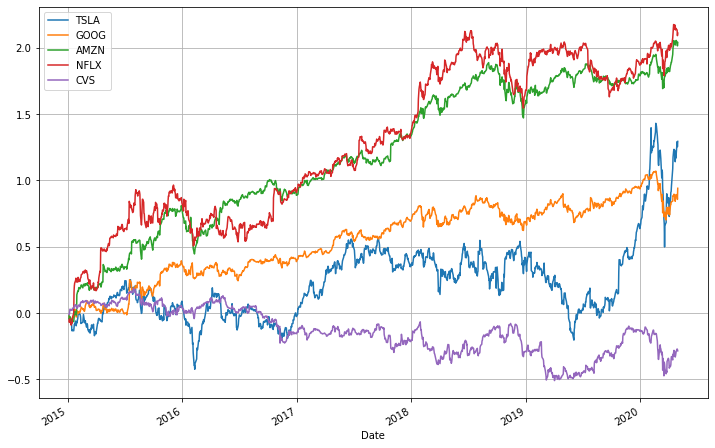

In [ ]:
hit_ratio = {}

for ticker in tickers:

    # compute the daily returns using the function we defined in Q1
    compute_daily_returns(ticker_df[ticker])

    # compute the hit ratio
    positive_trades = len(
        [i for i in ticker_df[ticker]['cc_returns'] if i > 0])
    negative_trades = len(
        [i for i in ticker_df[ticker]['cc_returns'] if i < 0])
    hit_ratio[ticker] = positive_trades/(positive_trades+negative_trades)
    print(f"Hit Ratio for {ticker} is : {hit_ratio[ticker]} \n")

    # compute the cumulative returns
    ticker_df[ticker]['cc_returns'] = ticker_df[ticker]['cc_returns'].cumsum()
    ticker_df[ticker]['cc_returns'].plot(
        grid=True, figsize=(12, 8), label=ticker)

plt.legend()
plt.show()